In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
dataset = pd.read_excel('Muscular_Data.xlsx')
target_column = dataset['Carrier']
independent_variables = dataset.drop('Carrier', axis = 1)
independent_variables['Pyrovate_Kinase'].fillna(independent_variables['Pyrovate_Kinase'].median(), inplace = True)
target_column = target_column.map({0:'class_0', 1: 'class_1'})
muscleDataFrame = independent_variables.join(pd.Series(target_column, name = 'class'))

In [3]:
between_class_feature_means = pd.DataFrame(columns=['class_0', 'class_1'])
for c, rows in muscleDataFrame.groupby('class'):
    between_class_feature_means[c] = rows.mean()
between_class_feature_means

,class_0,class_1
Age,28.813433,38.133333
creatine_Kinase,39.130597,187.186667
Hemopexin,82.944701,86.676400
Pyrovate_Kinase,12.186567,22.893333


In [4]:
within_class_scatter_matrix = np.zeros((muscleDataFrame.shape[1] - 1, muscleDataFrame.shape[1] - 1))

for c, rows in muscleDataFrame.groupby('class'):
    rows = rows.drop('class', axis = 1)
    s = np.zeros((muscleDataFrame.shape[1] - 1, muscleDataFrame.shape[1] - 1))

for index, row in rows.iterrows():
    x, mc = row.values.reshape(muscleDataFrame.shape[1] - 1, 1), between_class_feature_means[c].values.reshape(muscleDataFrame.shape[1] - 1, 1)
    s += (x - mc).dot((x - mc).T)

within_class_scatter_matrix += s

feature_means = muscleDataFrame.mean()
between_class_scatter_matrix = np.zeros((muscleDataFrame.shape[1] - 1, muscleDataFrame.shape[1] -1))
for c in between_class_feature_means:
    n = len(muscleDataFrame.loc[muscleDataFrame['class'] == c].index)
    mc, m = between_class_feature_means[c].values.reshape(muscleDataFrame.shape[1] - 1, 1), feature_means.values.reshape(muscleDataFrame.shape[1] - 1, 1)
    between_class_scatter_matrix += n + (mc - m).dot((mc - m).T)
between_class_scatter_matrix

array([[  255.89129183,   953.9157178 ,   227.77532531,   262.86904046],
       [  953.9157178 , 12042.74151136,   507.26508052,  1064.76433014],
       [  227.77532531,   507.26508052,   216.5176611 ,   230.56922361],
       [  262.86904046,  1064.76433014,   230.56922361,   270.88512636]])

In [5]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix) @ between_class_scatter_matrix)

In [6]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key = lambda x:x[0], reverse= True)
for pair in pairs:
    print(pair[0])

0.06631600495425886
0.0034751911178835158
5.896432336281702e-18
1.4913876502791487e-18


In [7]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance: ')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance: 
Eigenvector 0: 0.9502058810642643
Eigenvector 1: 0.049794118935735814
Eigenvector 2: 8.448676435042933e-17
Eigenvector 3: 2.1369280571399265e-17


In [8]:
matrix_W = np.hstack((pairs[0][1].reshape(muscleDataFrame.shape[1] - 1, 1), pairs[1][1].reshape(muscleDataFrame.shape[1] - 1, 1))).real
X_lda = np.array(independent_variables @ matrix_W)

In [9]:
le = LabelEncoder()
y = le.fit_transform(muscleDataFrame['class'])

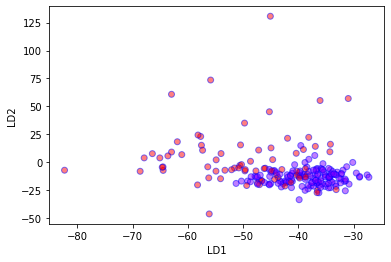

In [10]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='rainbow', alpha= 0.5, edgecolors= 'b')
plt.savefig('Classification Spread')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state= 23)

In [12]:
Model_1 = RandomForestClassifier()
Model_1.fit(X_train, y_train)
y_pred = Model_1.predict(X_test)

In [13]:
confusion_matrix(y_test, y_pred)
accuracy_1 = (np.sum(y_test == y_pred)) / len(y_test)
accuracy_1

0.8490566037735849

In [14]:
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)

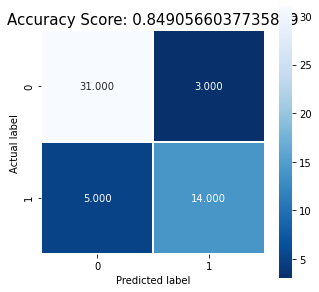

In [15]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_1)
plt.title(all_sample_title, size = 15);
plt.savefig('DA confusion matrix')